# Unsupervised Clustering (Autoencoding)

Related paper: [Unsupervised Deep Embedding for Clustering Analysis](https://arxiv.org/pdf/1511.06335.pdf)

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
from time import time
import keras.backend as K
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import callbacks
from tensorflow.keras.initializers import VarianceScaling

In [2]:
np.random.seed(10)

## Accuracy Metrics

Note: It should be noted that scikit-learn accuracy_score function does not give the accuracy score for the clustering since it does not permute the rows of the confusion matrix.<br>

Instead of using *accuracy_score*, we use [Kuhn-Munkres or Hungarian Algorithm](https://brc2.com/the-algorithm-workshop/)

In [23]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score,accuracy_score
from scipy.optimize import linear_sum_assignment as linear_assignment

nmi = normalized_mutual_info_score
ari = adjusted_rand_score
acc_score = accuracy_score

def acc(y_true, y_pred):
    """
    Calculate clustering accuracy

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    # Confusion matrix.
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for (i, j) in zip(ind[0],ind[1])]) * 1.0 / y_pred.size

## Set a baseline with K-Means

### Load the data (need to change)

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)

In [5]:
# 10 clusters
n_clusters = len(np.unique(y))
x.shape

(70000, 784)

In [6]:
# Train K-Means.
kmeans = KMeans(n_clusters=n_clusters,init='k-means++', n_init=20, algorithm='auto')
y_pred_kmeans = kmeans.fit_predict(x)
# Evaluate the K-Means clustering accuracy.
#accuracy_score(y,y_pred_kmeans)
acc(y, y_pred_kmeans)

0.5323571428571429

## Build Clustering Layer

The probability is calculated by student’s t-distribution. T-distribution, as same as used in the t-SNE algorithm, measure the similarity between an embedded point and a centroid.

Reference:[Making new layers and models via subclassing](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)

- ***build(input_shape)***: define the layer's weights,  the k clusters in k-D feature space, that is 10x10 weight variables.

- ***call(x)***: the layer logic lives, that is where the mapping from the features to clustering labels' magic happens.

- ***compute_output_shape(input_shape)***: specify here the shape transformation logic from input to output shapes.

Soft Assignemt (3.1.1)

In [45]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Basic Deep Clustering 

### Load the data (need to change)

### Autoencoder

In [8]:
def autoencoder(dims, act='relu', init='glorot_uniform(seed=0)'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

### Hyper-params

In [9]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(learning_rate=1, momentum=0.9)
pretrain_epochs = 30 #can be large
batch_size = 256
save_dir = './results'

In [10]:
autoencoder, encoder = autoencoder(dims, init=init)

c:\Users\greta\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [11]:
autoencoder.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None, 500)               1000500  

In [12]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
Total params: 1,665,010
Trainable params: 1,665,010
Non-trainable params: 0
_________________________________________________________________


### Pretrain auto-encoder

In [13]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/30
274/274 [==============================] - 7s 25ms/step - loss: 0.0644
Epoch 2/30
274/274 [==============================] - 7s 26ms/step - loss: 0.0438
Epoch 3/30
274/274 [==============================] - 7s 26ms/step - loss: 0.0324
Epoch 4/30
274/274 [==============================] - 7s 26ms/step - loss: 0.0269
Epoch 5/30
274/274 [==============================] - 7s 26ms/step - loss: 0.0241
Epoch 6/30
274/274 [==============================] - 7s 26ms/step - loss: 0.0225
Epoch 7/30
274/274 [==============================] - 7s 26ms/step - loss: 0.0212
Epoch 8/30
274/274 [==============================] - 7s 25ms/step - loss: 0.0203
Epoch 9/30
274/274 [==============================] - 7s 26ms/step - loss: 0.0195
Epoch 10/30
274/274 [==============================] - 7s 26ms/step - loss: 0.0189
Epoch 11/30
274/274 [==============================] - 7s 25ms/step - loss: 0.0184
Epoch 12/30
274/274 [==============================] - 7s 26ms/step - loss: 0.0179
Epoch 13/30
2

### Load the pre-trained auto encoder weights

In [14]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

### Build clustering model with autoencoder

In [15]:
clustering_layer = ClusteringLayer( n_clusters, name='clustering')(encoder.output)
auto_model = Model(inputs=encoder.input, outputs=clustering_layer)
auto_model.summary()
auto_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 clustering (ClusteringLayer  (None, 10)               100       
 )                                                               
                                                             

#### Step 1: initialize cluster centers using k-means

In [16]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
auto_model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

2188/2188 [==============================] - 6s 3ms/step


#### Step 2: deep clustering
Compute $p_i$ by first raising $q_i$ to the second power and then normalizing by frequency per cluster:

3.1.2

In [17]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [19]:
#initialize 
loss = 0
index = 0
maxiter = 800 # Can be change to large size
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.001 # tolerance threshold to stop training

#### Step 3 Start training

In [24]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = auto_model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            auto_acc = np.round(acc(y, y_pred), 5)
            auto_nmi = np.round(nmi(y, y_pred), 5)
            auto_ari = np.round(ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, auto_acc, auto_nmi, auto_ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = auto_model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

auto_model.save_weights(save_dir + '/DEC_model_final.h5')

Iter 0: acc = 0.80101, nmi = 0.71240, ari = 0.65947  ; loss= 0.04705
Iter 140: acc = 0.80657, nmi = 0.72453, ari = 0.67134  ; loss= 0.14357
Iter 280: acc = 0.81141, nmi = 0.73649, ari = 0.68226  ; loss= 0.19983
Iter 420: acc = 0.81684, nmi = 0.74697, ari = 0.69302  ; loss= 0.22093
Iter 560: acc = 0.81969, nmi = 0.75443, ari = 0.70057  ; loss= 0.22248
Iter 700: acc = 0.82191, nmi = 0.75908, ari = 0.70514  ; loss= 0.22352


### Load the clustering model trained weights

In [25]:
auto_model.load_weights(save_dir + '/DEC_model_final.h5')

### Evaluation

In [26]:
# Eval.
q = auto_model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    auto_acc = np.round(acc(y, y_pred), 5)
    auto_nmi = np.round(nmi(y, y_pred), 5)
    auto_ari = np.round(ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (auto_acc, auto_nmi, auto_ari), ' ; loss=', loss)

Acc = 0.82391, nmi = 0.76241, ari = 0.70919  ; loss= 0.22474


#### Confusion matrix

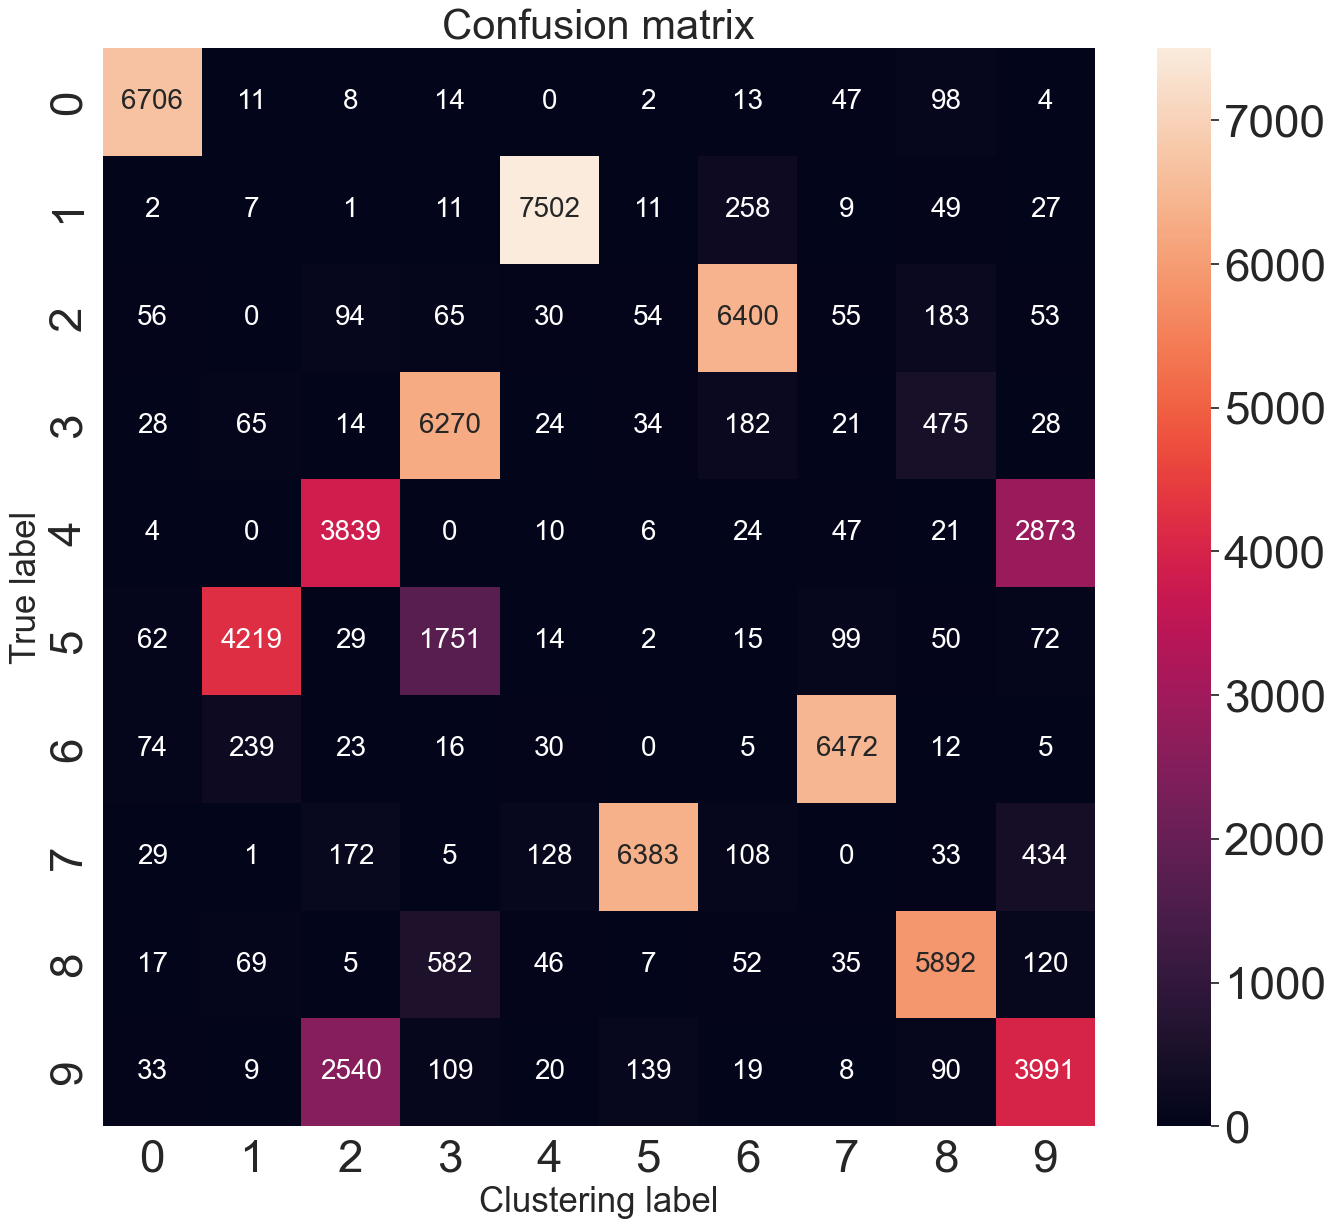

In [27]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Convolusional Auto-encoder

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
import numpy as np

### UpSampling2D

Using [up_sampling2d](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) to reconstruct the image

In [31]:
def autoencoder_conv2d_up(img_shape=(28, 28, 1)):
    """
    Conv2D auto-encoder model.
    Arguments:
        img_shape: e.g. (28, 28, 1) for MNIST
    return:
        (autoencoder, encoder), Model of autoencoder and model of encoder
    """
    input_img = Input(shape=img_shape)
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    shape_before_flattening = K.int_shape(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    x = Flatten()(x)
    encoded = Dense(10, activation='relu', name='encoded')(x)

    # Decoder
    x = Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(encoded)
    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape(shape_before_flattening[1:])(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [32]:
autoencoder_up, encoder_up = autoencoder_conv2d_up()

In [33]:
autoencoder_up.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 encoded (Dense)             (None, 10)                1290      
                                                                 
 dense (Dense)               (None, 128)               1408     

In [34]:
encoder_up.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 encoded (Dense)             (None, 10)                1290      
                                                                 
Total params: 3,194
Trainable params: 3,194
Non-trainable p

#### Load data for convolutional input

In [35]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape(x.shape + (1,))
x = np.divide(x, 255.)

#### Pretrain covolutional autoencoder

In [36]:
pretrain_epochs = 30
batch_size = 256
autoencoder_up.compile(optimizer='adadelta', loss='mse')
autoencoder_up.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder_up.save_weights(save_dir+'/conv_ae_weights.h5')

Epoch 1/30
274/274 [==============================] - 17s 59ms/step - loss: 0.2326
Epoch 2/30
274/274 [==============================] - 16s 58ms/step - loss: 0.2319
Epoch 3/30
274/274 [==============================] - 16s 58ms/step - loss: 0.2310
Epoch 4/30
274/274 [==============================] - 16s 58ms/step - loss: 0.2296
Epoch 5/30
274/274 [==============================] - 16s 58ms/step - loss: 0.2281
Epoch 6/30
274/274 [==============================] - 16s 58ms/step - loss: 0.2265
Epoch 7/30
274/274 [==============================] - 16s 58ms/step - loss: 0.2249
Epoch 8/30
274/274 [==============================] - 16s 58ms/step - loss: 0.2231
Epoch 9/30
274/274 [==============================] - 16s 58ms/step - loss: 0.2212
Epoch 10/30
274/274 [==============================] - 16s 57ms/step - loss: 0.2191
Epoch 11/30
274/274 [==============================] - 16s 57ms/step - loss: 0.2169
Epoch 12/30
274/274 [==============================] - 16s 59ms/step - loss: 0.2143
E

In [37]:
autoencoder_up.load_weights(save_dir+'/conv_ae_weights.h5')

#### Build clustering model with convolutional autoencoder

In [46]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder_up.output)
model_up = Model(inputs=encoder_up.input, outputs=clustering_layer)
model_up.compile(optimizer='adam', loss='kld')
model_up.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 encoded (Dense)             (None, 10)                1290      
                                                                 
 clustering (ClusteringLayer  (None, 10)               100 

##### Step 1: initialize cluster centers using k-means

In [41]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder_up.predict(x))
y_pred_last = np.copy(y_pred)
model_up.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

2188/2188 [==============================] - 2s 887us/step


##### Step 2: deep clustering

In [47]:
loss = 0
index = 0
maxiter = 800
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.001 # tolerance threshold to stop training

#### Start training

In [48]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model_up.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc_up = np.round(acc(y, y_pred), 5)
            nmi_up = np.round(nmi(y, y_pred), 5)
            ari_up = np.round(ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc_up, nmi_up, ari_up), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model_up.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model_up.save_weights(save_dir + '/conv_DEC_model_final.h5')

Iter 0: acc = 0.12443, nmi = 0.01862, ari = 0.00077  ; loss= 0
Iter 140: acc = 0.15260, nmi = 0.05361, ari = 0.00853  ; loss= 0.0
Iter 280: acc = 0.19903, nmi = 0.08618, ari = 0.03000  ; loss= 2e-05
Iter 420: acc = 0.20364, nmi = 0.08382, ari = 0.04086  ; loss= 0.00014
Iter 560: acc = 0.21124, nmi = 0.08677, ari = 0.04609  ; loss= 0.00113
Iter 700: acc = 0.21787, nmi = 0.09568, ari = 0.05212  ; loss= 0.00941


#### Load the clustering model trained weights

In [49]:
model_up.load_weights(save_dir + '/conv_DEC_model_final.h5')

#### Evaluation

In [50]:
# Eval.
q = model_up.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc_up = np.round(acc(y, y_pred), 5)
    nmi_up = np.round(nmi(y, y_pred), 5)
    ari_up = np.round(ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc_up, nmi_up, ari_up), ' ; loss=', loss)

Acc = 0.22216, nmi = 0.10033, ari = 0.05575  ; loss= 0.03753


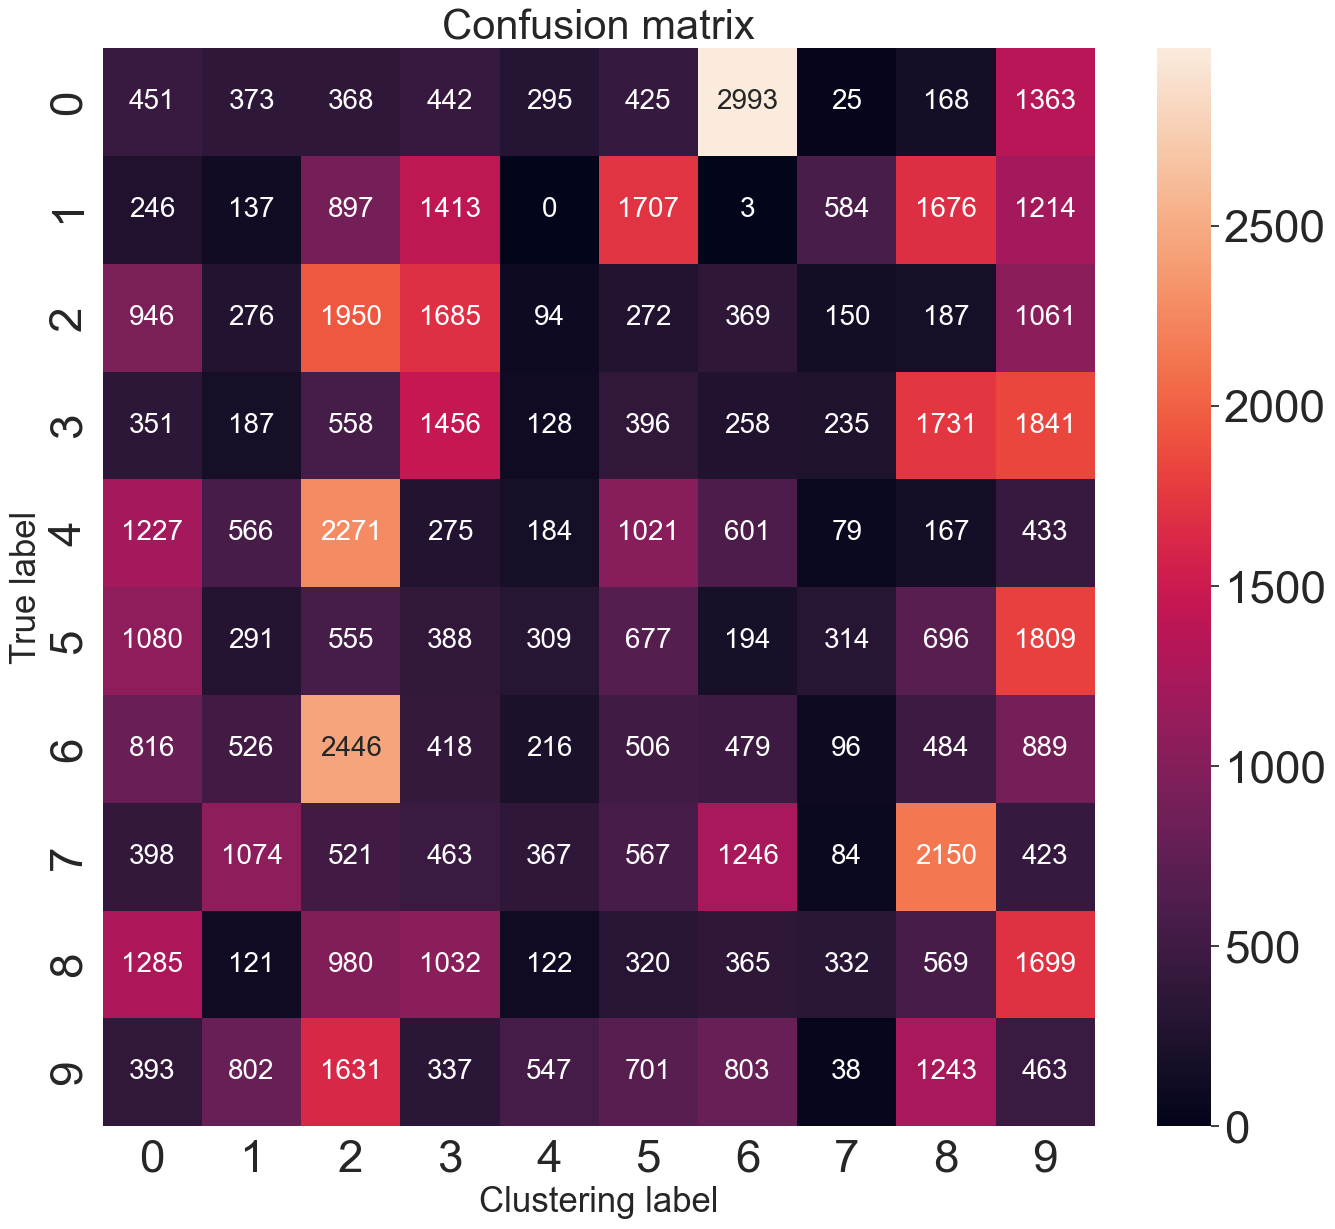

In [51]:
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

### Convolution2D Transpose

Using [convolution2d_transpose](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/)

In [52]:
def autoencoder_conv2d_t(input_shape=(28, 28, 1), filters=[32, 64, 128, 10]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [53]:
autoencoder_t, encoder_t = autoencoder_conv2d_t()

In [54]:
autoencoder_t.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 14, 14, 32)        832       
                                                                 
 conv2 (Conv2D)              (None, 7, 7, 64)          51264     
                                                                 
 conv3 (Conv2D)              (None, 3, 3, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 embedding (Dense)           (None, 10)                11530     
                                                                 
 dense_1 (Dense)             (None, 1152)              12672    

#### Load data for convolutional input

In [55]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape(x.shape + (1,))
x = np.divide(x, 255.)

#### Pretrain covolutional autoencoder

In [56]:
pretrain_epochs = 30
batch_size = 256
autoencoder_t.compile(optimizer='adadelta', loss='mse')
autoencoder_t.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder_t.save_weights(save_dir+'/conv_t_ae_weights.h5')

Epoch 1/30
274/274 [==============================] - 17s 60ms/step - loss: 0.1121
Epoch 2/30
274/274 [==============================] - 16s 57ms/step - loss: 0.1117
Epoch 3/30
274/274 [==============================] - 16s 57ms/step - loss: 0.1112
Epoch 4/30
274/274 [==============================] - 16s 57ms/step - loss: 0.1106
Epoch 5/30
274/274 [==============================] - 16s 57ms/step - loss: 0.1100
Epoch 6/30
274/274 [==============================] - 16s 57ms/step - loss: 0.1094
Epoch 7/30
274/274 [==============================] - 16s 57ms/step - loss: 0.1088
Epoch 8/30
274/274 [==============================] - 16s 57ms/step - loss: 0.1082
Epoch 9/30
274/274 [==============================] - 16s 58ms/step - loss: 0.1075
Epoch 10/30
274/274 [==============================] - 16s 58ms/step - loss: 0.1069
Epoch 11/30
274/274 [==============================] - 16s 58ms/step - loss: 0.1062
Epoch 12/30
274/274 [==============================] - 16s 58ms/step - loss: 0.1055
E

In [57]:
autoencoder_t.load_weights(save_dir+'/conv_t_ae_weights.h5')

#### Build clustering model with convolutional autoencoder

In [58]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder_t.output)
model_t = Model(inputs=encoder_t.input, outputs=clustering_layer)
model_t.compile(optimizer='adam', loss='kld')
model_t.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 14, 14, 32)        832       
                                                                 
 conv2 (Conv2D)              (None, 7, 7, 64)          51264     
                                                                 
 conv3 (Conv2D)              (None, 3, 3, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 embedding (Dense)           (None, 10)                11530     
                                                                 
 clustering (ClusteringLayer  (None, 10)               100 

##### Step 1: initialize cluster centers using k-means

In [59]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder_t.predict(x))

2188/2188 [==============================] - 6s 3ms/step


In [60]:
y_pred_last = np.copy(y_pred)
model_t.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

##### Step 2: deep clustering

In [61]:
loss = 0
index = 0
maxiter = 800
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.001 # tolerance threshold to stop training

#### Start training

In [62]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model_t.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc_t = np.round(acc(y, y_pred), 5)
            nmi_t = np.round(nmi(y, y_pred), 5)
            ari_t = np.round(ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc_t, nmi_t, ari_t), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model_t.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model_t.save_weights(save_dir + '/conv_t_DEC_model_final.h5')

Iter 0: acc = 0.30663, nmi = 0.19251, ari = 0.12255  ; loss= 0
Iter 140: acc = 0.31323, nmi = 0.19290, ari = 0.12800  ; loss= 0.0
Iter 280: acc = 0.32110, nmi = 0.20957, ari = 0.13790  ; loss= 0.0
Iter 420: acc = 0.32229, nmi = 0.21149, ari = 0.14047  ; loss= 0.0
Iter 560: acc = 0.32389, nmi = 0.21550, ari = 0.14296  ; loss= 0.0
Iter 700: acc = 0.32401, nmi = 0.21451, ari = 0.14335  ; loss= 1e-05


#### Load the clustering model trained weights

In [63]:
model_t.load_weights(save_dir + '/conv_t_DEC_model_final.h5')

#### Evaluation

In [64]:
# Eval.
q = model_t.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc_t = np.round(acc(y, y_pred), 5)
    nmi_t = np.round(nmi(y, y_pred), 5)
    ari_t = np.round(ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc_t, nmi_t, ari_t), ' ; loss=', loss)

Acc = 0.32119, nmi = 0.21122, ari = 0.14028  ; loss= 2e-05


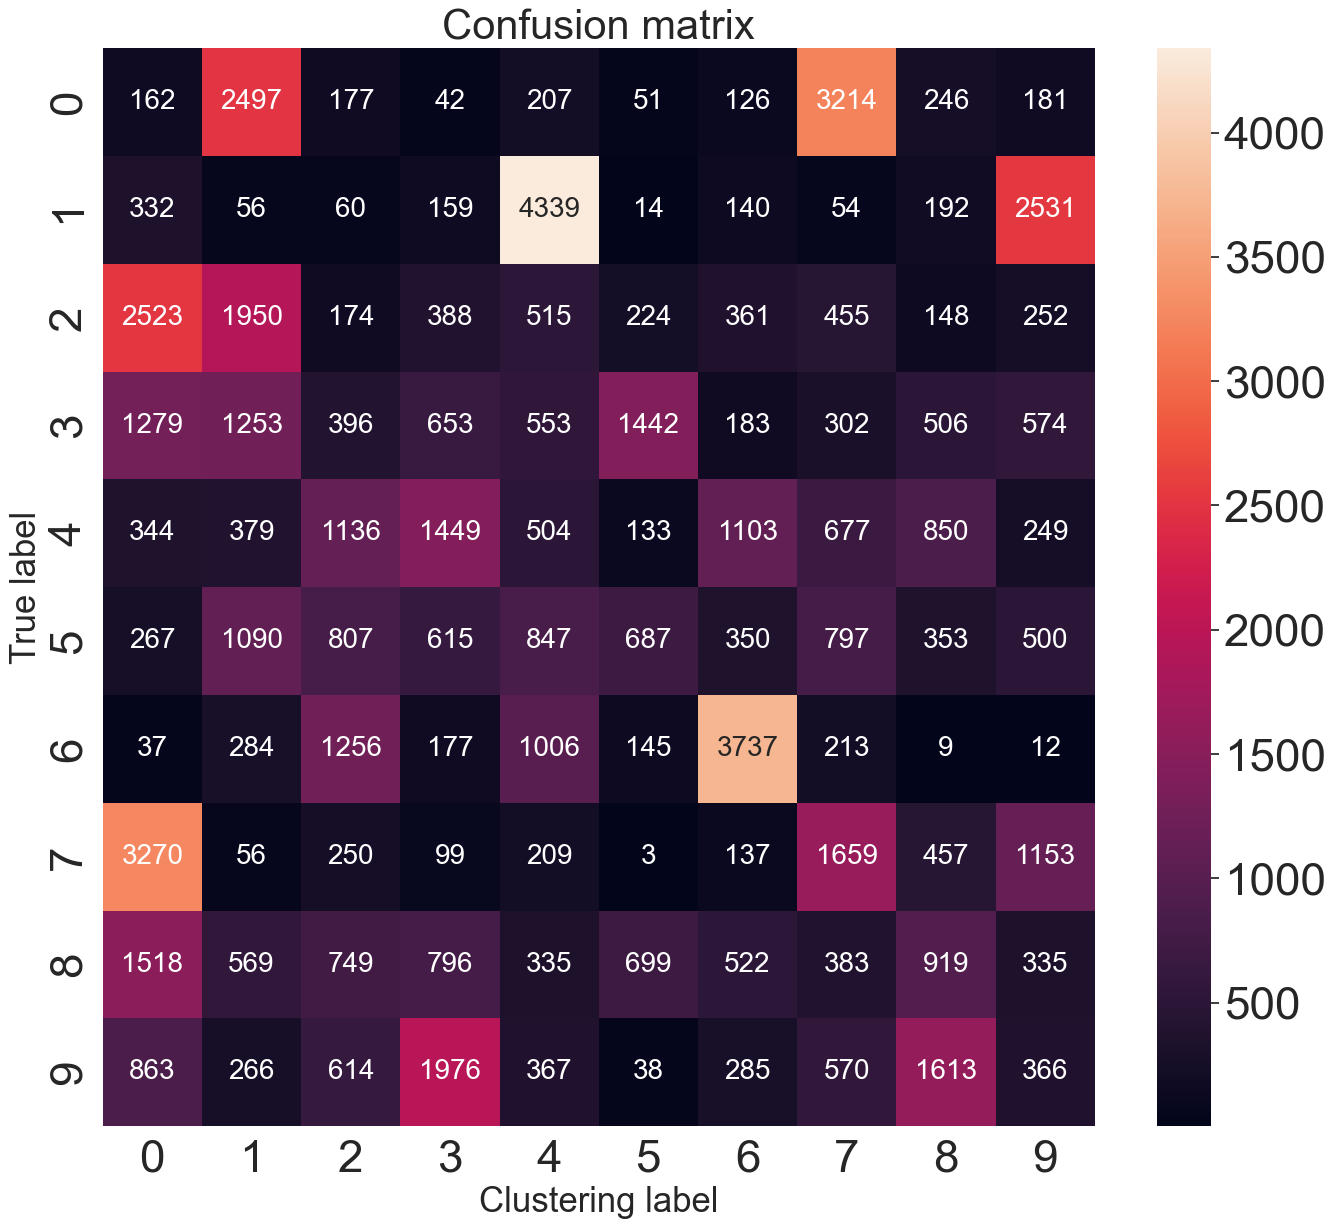

In [65]:
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Model to train clustering and autoencoder at same time(Convolutional)
Multiple outputs model.

In [68]:
autoencoder_t, encoder_t = autoencoder_conv2d_t()
autoencoder_t.load_weights(save_dir+'/conv_t_ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder_t.output)
model_m = Model(inputs=encoder_t.input,
                           outputs=[clustering_layer, autoencoder_t.output])
model_m.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 14, 14, 32)   832         ['input_5[0][0]']                
                                                                                                  
 conv2 (Conv2D)                 (None, 7, 7, 64)     51264       ['conv1[0][0]']                  
                                                                                                  
 conv3 (Conv2D)                 (None, 3, 3, 128)    73856       ['conv2[0][0]']                  
                                                                                            

### Initialize cluster centers using k-means

In [69]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder_t.predict(x))
model_m.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

2188/2188 [==============================] - 5s 2ms/step


In [71]:
model_m.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

In [72]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model_m.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc_m = np.round(acc(y, y_pred), 5)
            nmi_m = np.round(nmi(y, y_pred), 5)
            ari_m = np.round(ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc_m, nmi_m, ari_m), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model_m.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model_m.save_weights(save_dir + '/conv_b_DEC_model_final.h5')

Iter 0: acc = 0.30629, nmi = 0.19216, ari = 0.12213  ; loss= 2e-05
Iter 140: acc = 0.37659, nmi = 0.35385, ari = 0.22124  ; loss= [0.03323 0.      0.03323]
Iter 280: acc = 0.35764, nmi = 0.35667, ari = 0.21122  ; loss= [0.02295 0.      0.02295]
Iter 420: acc = 0.33077, nmi = 0.35169, ari = 0.19572  ; loss= [0.02004 0.      0.02004]
Iter 560: acc = 0.33121, nmi = 0.34314, ari = 0.18522  ; loss= [0.01672 0.      0.01672]
Iter 700: acc = 0.33326, nmi = 0.34964, ari = 0.18403  ; loss= [0.01639 0.      0.01639]


### Load the clustering model trained weights

In [73]:
model_m.load_weights(save_dir + '/conv_b_DEC_model_final.h5')

### Evaluation

In [74]:
# Eval.
q, _ = model_m.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc_m = np.round(acc(y, y_pred), 5)
    nmi_m = np.round(nmi(y, y_pred), 5)
    ari_m = np.round(ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc_m, nmi_m, ari_m), ' ; loss=', loss)

Acc = 0.34609, nmi = 0.36024, ari = 0.19383  ; loss= [1.572e-02 2.000e-05 1.572e-02]


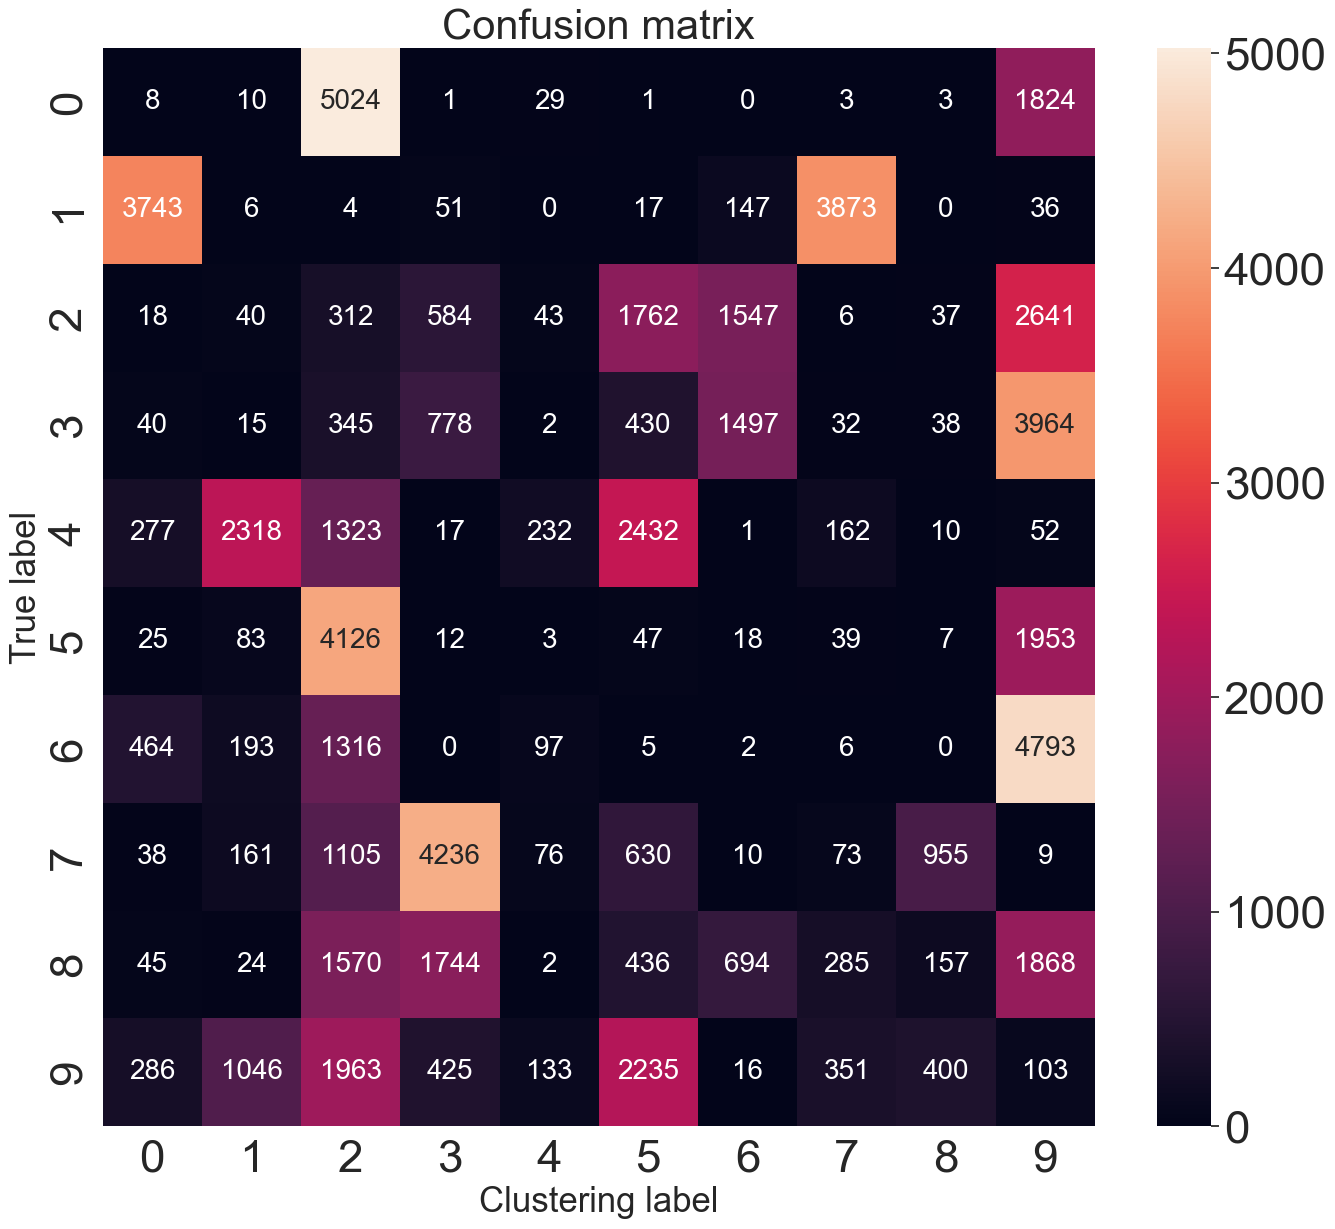

In [75]:
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Model to train clustering and autoencoder at same time(Fully connected)
Multiple outputs model.

In [76]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)
n_clusters = len(np.unique(y))
x.shape

(70000, 784)

In [79]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(learning_rate=1, momentum=0.9)
pretrain_epochs = 30
batch_size = 256
save_dir = './results'

In [80]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [82]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.load_weights(save_dir+'/ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
            outputs=[clustering_layer, autoencoder.output])


ValueError: Layer "AE" expects 1 input(s), but it received 5 input tensors. Inputs received: [<tf.Tensor: shape=(), dtype=int32, numpy=784>, <tf.Tensor: shape=(), dtype=int32, numpy=500>, <tf.Tensor: shape=(), dtype=int32, numpy=500>, <tf.Tensor: shape=(), dtype=int32, numpy=2000>, <tf.Tensor: shape=(), dtype=int32, numpy=10>]

In [83]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoder_0 (Dense)              (None, 500)          392500      ['input[0][0]']                  
                                                                                                  
 encoder_1 (Dense)              (None, 500)          250500      ['encoder_0[0][0]']              
                                                                                                  
 encoder_2 (Dense)              (None, 2000)         1002000     ['encoder_1[0][0]']              
                                                                                            

### Initialize cluster centers using k-means

In [84]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

2188/2188 [==============================] - 7s 3ms/step


In [85]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [88]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc_s = np.round(acc(y, y_pred), 5)
            nmi_s = np.round(nmi(y, y_pred), 5)
            ari_s = np.round(ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc_s, nmi_s, ari_s), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

Iter 0: acc = 0.79824, nmi = 0.70855, ari = 0.65315  ; loss= [1.572e-02 2.000e-05 1.572e-02]
Iter 140: acc = 0.80643, nmi = 0.71948, ari = 0.66741  ; loss= [0.01987 0.03745 0.01613]
Iter 280: acc = 0.81439, nmi = 0.73326, ari = 0.68274  ; loss= [0.0303  0.10386 0.01991]
Iter 420: acc = 0.82009, nmi = 0.74429, ari = 0.69384  ; loss= [0.03658 0.14626 0.02196]
Iter 560: acc = 0.82590, nmi = 0.75350, ari = 0.70458  ; loss= [0.03833 0.15941 0.02239]
Iter 700: acc = 0.82639, nmi = 0.75555, ari = 0.70515  ; loss= [0.03798 0.15549 0.02243]


### Load the clustering model trained weights

In [89]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')

### Final Evaluation

In [90]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc_s = np.round(acc(y, y_pred), 5)
    nmi_s = np.round(nmi(y, y_pred), 5)
    ari_s = np.round(ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc_s, nmi_s, ari_s), ' ; loss=', loss)

Acc = 0.82703, nmi = 0.75898, ari = 0.70725  ; loss= [0.03709 0.15015 0.02208]


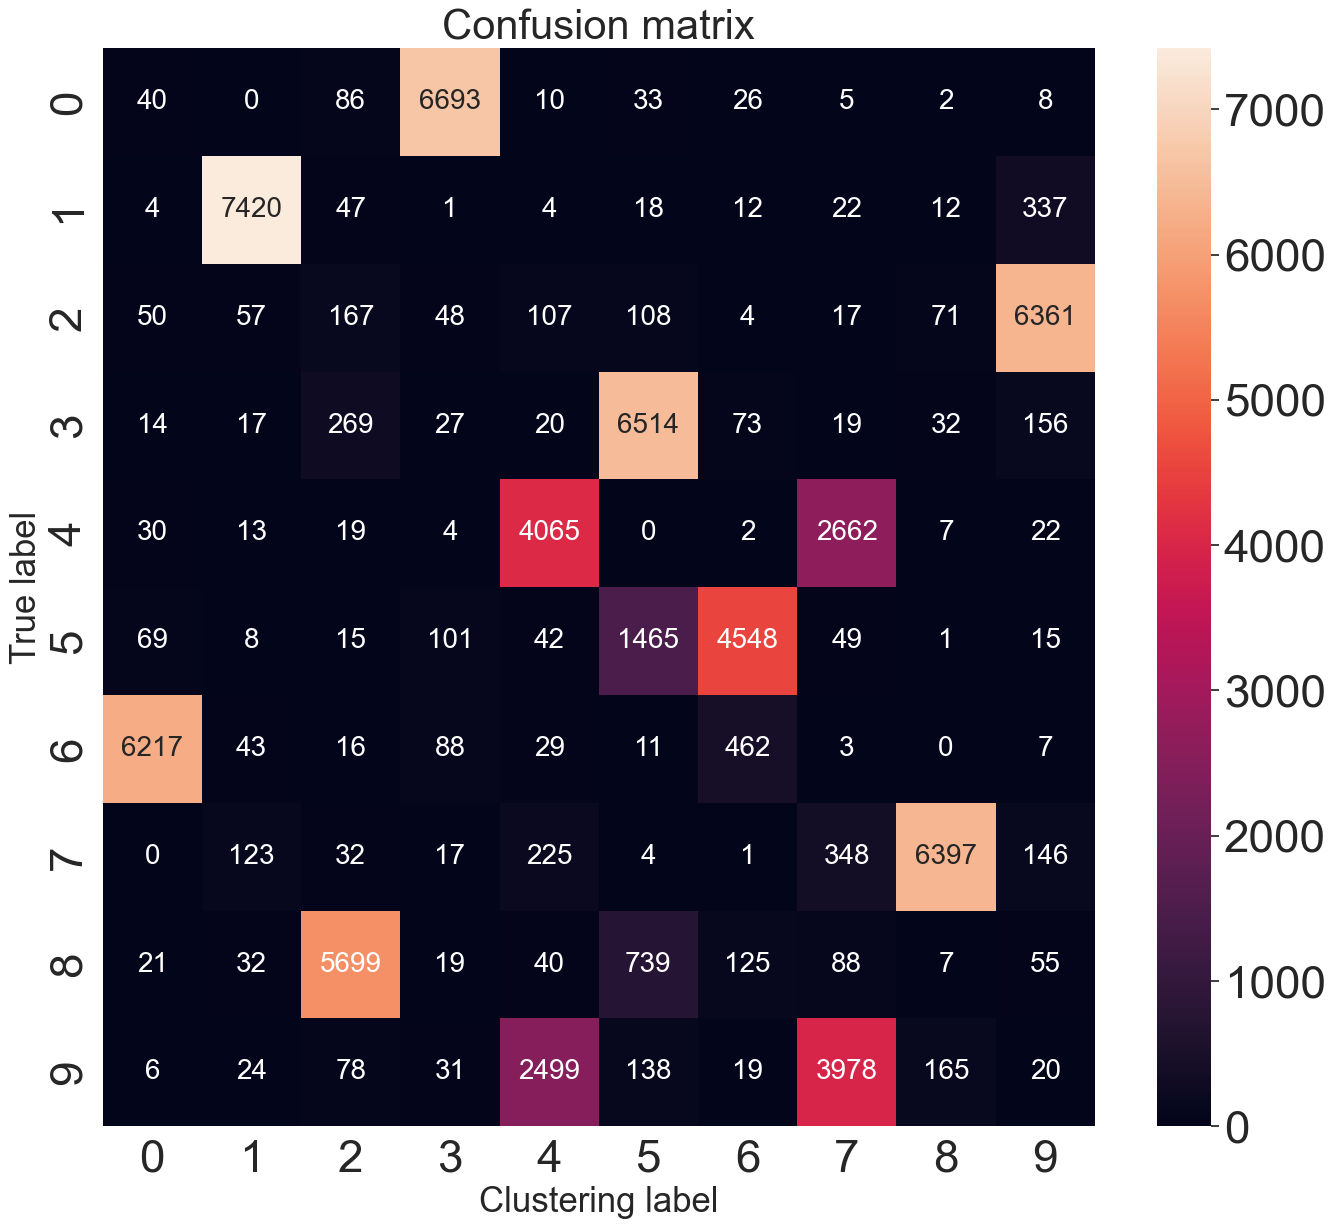

In [91]:
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()